## 3DCoMPaT: 2D Dataloader Demo

We give here a few pointers as to how to easily manipulate the 2D rendered data from the 3DCoMPaT dataset.

All **3D shapes** in our dataset are identified by a unique 36 characters string, which also identifies all views and metadata pertaining a specific shape.

To run the code below, you will need the following dependencies:

<ul>
  <li>numpy</li>
  <li>matplotlib</li>
  <li>torch</li>
  <li>torchvision</li>
</ul>	

### Table of Contents
1. [2D Shape classification](#shape-classification)
2. [2D Part segmentation](#part-segmentation)
3. [2D Grounded CoMPaT Recognition](#grounded-compat-recognition)
4. [2D CoMPaT Benchmark](#benchmark)


In [1]:
"""
3DCoMPaT 2D Dataloader Demo
"""
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as T


ROOT_URL = './data/'


def make_transform(mode):
    if mode == "train":
        return T.Compose(
            [
                # You can add here your own set of data transformations for training
            ]
        )
    elif mode == "val":
        return T.Compose([])


def show_tensors(ims, size):
    """
    Displaying an image in the notebook.
    """
    n_ims = len(ims)
    f, axarr = plt.subplots(1, n_ims)
    f.set_size_inches(size, size*n_ims)
    if n_ims == 1: axarr = [axarr]
    for im, ax in zip(ims, axarr):
        ax.axis('off')
        im = np.array(torch.squeeze(im).permute(1, 2, 0))
        im = im/np.amax(im)
        ax.imshow(im)

### Shape classification


For the 2D shape classification task, we instantiate a simple ShapeLoader which only loads 2D rendered views.

In [2]:
"""
Shape classification data loader.

    Iterating over 2D renderings of shapes, with a shape category label.

    Args:
        root_url:    Base dataset URL containing data split shards
        split:       One of {train, val}.
        n_comp:      Number of compositions per shape to use
        transform:   Transform to be applied on rendered views
        view_type:   Filter by view type [0: canonical views, 1: random views]

"""
from compat2D import ShapeLoader

The **ShapeLoader** is parameterized by the datasplit to be loaded, and by the number of compositions to use per shape.

We can instantiate a dataloader for all viewtypes using the demo data:

In [3]:
# Making a basic 2D dataloader
shape_loader = (
    ShapeLoader(root_url=ROOT_URL, split="val", n_comp=1, transform=make_transform("val"))
    .make_loader(batch_size=1, num_workers=1)
)

# Iterating over the dataloader and storing the first 4 images
my_tensors = []
for k, (image, target) in enumerate(shape_loader):
    my_tensors += [image]
    if k==7: break

# Displaying the first 8 images (4 canonical views, 4 random views)
show_tensors(my_tensors, size=25)

KeyError: 'val'

We can also choose to select only canonical views or random views, using the `view_type` parameter:

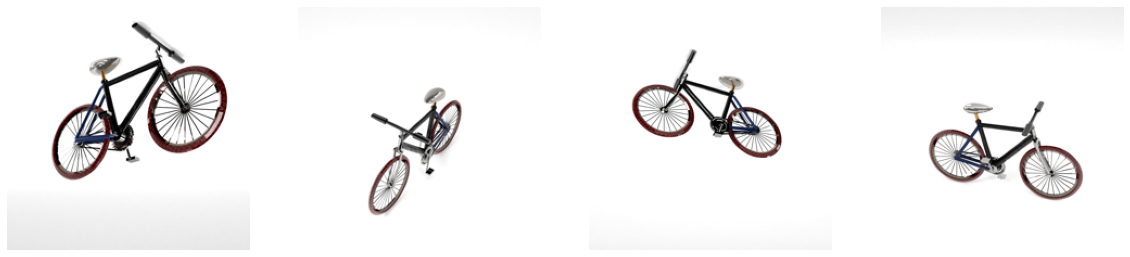

In [ ]:
# Making a filtered 2D dataloader
shape_loader_canonical = (
    ShapeLoader(root_url=ROOT_URL, split="val", n_comp=1, transform=make_transform("val"), view_type=1)
    .make_loader(batch_size=1, num_workers=1)
)

# Displaying the first 4 random views
my_tensors = [t[0] for t in list(shape_loader_canonical)[:4]]
show_tensors(my_tensors, size=20)

### Part segmentation

For the 2D part segmentation task, we want shape labels and a segmentation mask, alongside the mask code data.

In [ ]:
"""
Part segmentation and shape classification data loader.

    Iterating over 2D renderings of models with a shape category label, and a segmentation mask with pixel coding for parts.

    Args:
        root_url:        Base dataset URL containing data split shards
        split:           One of {train, val}.
        n_comp:          Number of compositions to use
        view_type:       Filter by view type [0: canonical views, 1: random views]
        transform:       Transform to be applied on rendered views

        mask_transform:  Transform to apply on segmentation masks
        code_transform:  Function to apply on segmentation mask labels 

"""
from compat2D import SegmentationLoader

The **SegmentationLoader** has the same parameters as the ShapeLoader, with the addition of custom funtions to be applied to the segmentation mask or mask code.

We display a rendering and its segmentation mask, alongside the mask metadata, for a single view:

>> Mask pixel coding:
{'pedal': 20, 'tyre': 40, 'saddle': 60, 'seat_stay': 80, 'spokes': 100, 'chain_stay': 120, 'handlebars': 140, 'fork': 160, 'headset': 180, 'tube': 200, 'chain': 220, 'rim': 240} 

>> Mask pixel values:
[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240] 

>> View (left) and associated mask (right):


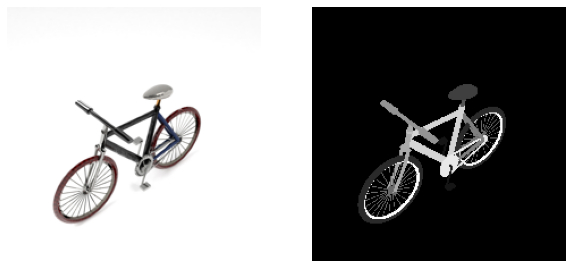

In [ ]:
# Making a basic 2D dataloader
part_seg_loader = (
    SegmentationLoader(root_url=ROOT_URL, split="val", n_comp=1, transform=make_transform("val"))
    .make_loader(batch_size=1, num_workers=1)
)

# Iterating over the loader and displaying the data
for image, target, mask, mask_code in part_seg_loader:
    mask_code = mask_code[0]
    print(">> Mask pixel coding:")
    print(mask_code, "\n")

    print(">> Mask pixel values:")
    print([int(v) for v in list(torch.unique(mask))], "\n")

    print(">> View (left) and associated mask (right):")
    if image.shape[0] == 1:
        show_tensors([image, mask], size=10)
    break

These mask codes can be used directly as a ground truth for any 2D segmentation task.

Here, we illustrate their usage by turning all `tyres` appearing in the mask to pink:

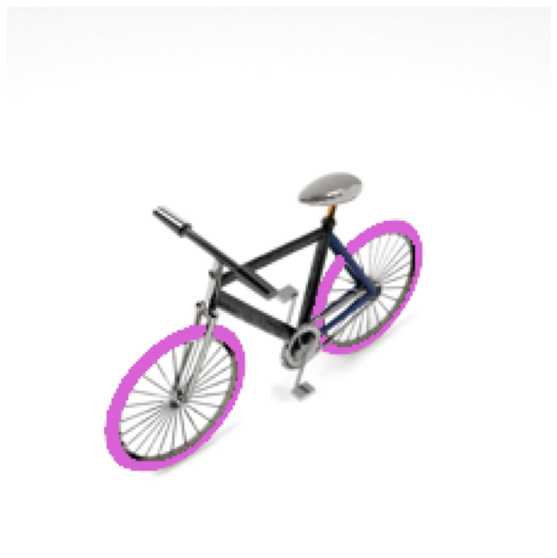

In [ ]:
def replace_RGB(mask, im, rgb_0, rgb_1):
    im_colored = im.clone()
    for k in [0, 1, 2]:
        im_colored[:, k, :, :][mask[:, k, :, :] == rgb_0[k]] = rgb_1[k]/255.

    return im_colored

# Replacing the pixel code for tyres to pink
pink_rgb = [215, 97, 213]
tyre_rgb = [mask_code['tyre']]*3

# Displaying the result
new_image = replace_RGB(mask, image, tyre_rgb, pink_rgb)
show_tensors(new_image, size=10)

### Grounded CoMPaT Recognition



In [ ]:
"""
Dataloader for the full 2D compositional task.

    Iterating over 2D renderings of models with:
        - shape category label
        - segmentation mask with pixel coding for parts
        - part materials labels

    Args:
        root_url:        Base dataset URL containing data split shards
        split:           One of {train, val}.
        n_comp:          Number of compositions to use
        view_type:       Filter by view type [0: canonical views, 1: random views]
        transform:       Transform to be applied on rendered views

        mask_transform:      Transform to apply on segmentation masks
        code_transform:      Function to apply on segmentation mask labels 
        part_mat_transform:  Function to apply on part-material labels

"""
from compat2D import GCRLoader

The **GCRLoader** provides part-material tuples in addition to all of the data provided by the part segmentation loader.

We highlight its usage in the code snippet below:

>> Mask pixel coding:
{'pedal': 20, 'tyre': 40, 'saddle': 60, 'seat_stay': 80, 'spokes': 100, 'chain_stay': 120, 'handlebars': 140, 'fork': 160, 'headset': 180, 'tube': 200, 'chain': 220, 'rim': 240}
>> Part-material information:
{'pedal': 'metal', 'tyre': 'rubber', 'saddle': 'metal', 'seat_stay': 'metal', 'spokes': 'metal', 'chain_stay': 'metal', 'handlebars': 'metal', 'fork': 'metal', 'headset': 'metal', 'tube': 'metal', 'chain': 'metal', 'rim': 'metal'}


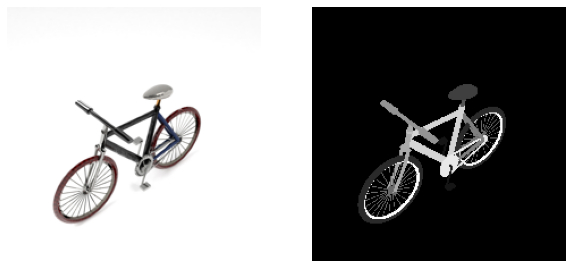

In [ ]:
gcr_loader = (
    GCRLoader(root_url=ROOT_URL, split="val", n_comp=1, transform=make_transform("val"))
    .make_loader(batch_size=1, num_workers=1)
)

for image, target, mask, mask_code, part_mat in gcr_loader:
    if image.shape[0] == 1:
        show_tensors([image, mask], size=10)
    print(">> Mask pixel coding:")
    print(mask_code[0])
    print(">> Part-material information:")
    print(part_mat[0])
    break

### Benchmark

In **"benchmark2D.py"**, we also provide pre-configured 2D benchmarks for the 2D tasks, for CoMPaT10 and CoMPaT50.

These benchmarks are the official 2D benchmarks for 3DCoMPaT.

The provided classes are listed below:

**CoMPaT10 Benchmark:**

<ul>
  <li>CoMPaT10_ShapeLoader</li>
  <li>CoMPaT10_SegmentationLoader</li>
  <li>CoMPaT10_GCRLoader</li>
</ul>	


**CoMPaT50 Benchmark:**

<ul>
  <li>CoMPaT50_ShapeLoader</li>
  <li>CoMPaT50_SegmentationLoader</li>
  <li>CoMPaT50_GCRLoader</li>
</ul>	

